In [1]:
# Load in necessary packages
# specify where the parsed geo data lives
# Specify where processed data will go
library(dplyr)
library(stringr)
library(foreach)
library(jsonlite)
library(purrr)
library(tidyr)
library(readr)
# To Install DirichletMultinomial: First install bioconducts, then install 
# package using BiocManage::install("DirichletMultinomial") 
# https://bioconductor.org/install/
library(DirichletMultinomial)
library(broom)
library(scales)
library(usmap)
library(ggplot2)
geo_data_directory <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/safe_graph_geos/2020/'
processed_data_directory <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/'
fig_directory <- paste(processed_data_directory, 'safe_graph_geos/figs/', sep="")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:jsonlite’:

    flatten


The following objects are masked from ‘package:foreach’:

    accumulate, when


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following

In [2]:
# Specify the set of months used to generate geo-adj matrix. Only use
# jan and feb, bc pre-COVID
months <- c('01', '02')

# Cycle through months
data_wrapped <- foreach(i = months, .combine='rbind') %do% {
    # Get the relevant directory
    directory = str_c(geo_data_directory, i)
    
    # How many days in each month?
    n_days = case_when(i == '01' ~ 31,
                  i == '02' ~ 29,
                  i == '03' ~ 31,
                  i == '04' ~ 19)
    
    # Loop through the days
    data_aggregate_month <- foreach(j = seq(1, n_days, 1), .combine='rbind') %do% {
        # Specify a date string, and read in the relevant file
        day_string <- str_pad(as.character(j), 2, '0', side='left')
        file = str_c(directory, '/2020', as.character(i), as.character(day_string), '_county_graph.txt')
        data = read_tsv(file, 
                        col_types = cols(
                            X1 = col_integer(),
                            `origin-county` = col_integer(),
                            `dest-county` = col_integer(),
                            `num-devices` = col_integer()
                        ))
        # Add the days date to the dataframe
        data <- data %>% 
          mutate(ds = str_c('2020-', i, '-', day_string))
        
        # Rename df so its easy to read
        names(data) <- c('rn', 'origin_county', 'destination_county', 'num_devices', 'ds')

        # Remove row number and return
        data <- data %>% dplyr::select(-rn)
    }
}

Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Missing column names f

In [3]:
# missing entry for a very small county in HI
missing_counties <- data.frame(
    origin_county=15005, destination_county=15005, total_devices=0
)

In [4]:
# Summarise by origin-destination pair.
# Filter out any origin or destination counties
# not in the 50 states (i.e., in US terrritories)
geo_adj <- data_wrapped %>% 
    group_by(origin_county, destination_county) %>% 
    summarise(total_devices = sum(num_devices)) %>% 
    ungroup() %>% 
    filter(origin_county <= 57000 & destination_county <= 57000) %>%
    rbind(missing_counties)

Row $i$ in this matrix will represent travel from $i$ to each other county.

In [5]:
# Spread this into a matrix and fill in with zeros when/if necessary.
geo_adj %>% 
    select(origin_county, destination_county, total_devices) %>%
    spread(key = destination_county, value = total_devices, fill=0) %>%
    ungroup() %>%
    select(-origin_county) %>%
    as.matrix() -> geo_adj_matrix

In [6]:
# Remove that one row with no observations, 
# and generate a matrix to be used when generating a prior for empirical Bayes 
# based on the observed data.
geo_adj_matrix_0_diag <- geo_adj_matrix
diag(geo_adj_matrix_0_diag) <- 0
geo_adj_matrix_for_empirical_prior <- geo_adj_matrix_0_diag[rowSums(
    geo_adj_matrix_0_diag) != 0L,]

In [7]:
# Obtain a prior for empirical Bayes
dm_fit <- DirichletMultinomial::dmn(geo_adj_matrix_for_empirical_prior, 1)

The parameters estimated here are the $\alpha_i$'s for the Dirichlet. Let $K = \sum(\alpha_i)$. Given the (empirical) prior, the expected proportions are $\gamma_i = E(\pi_i) = \alpha_i / K$. The posterior estimate combines the observed proportions $p_i$ with this prior $\hat{\pi}_i = [n/(n+K)]p_i + [K/(n + K)]\gamma_i$.

See Agresti, A., & Hitchcock, D. B. (2005). Bayesian inference for categorical data analysis. Statistical Methods and Applications, 14(3), 297-330. https://doi.org/10.1007/s10260-005-0121-y

In [8]:
# Get the prior into an object we can interface with easily
tidy.DMN <- function(x, ...) {
  ret <- as.data.frame(x@fit)
  tbl_df(fix_data_frame(ret, c("conf.low", "estimate", "conf.high")))
}
dm_params <- tidy(dm_fit)

# Get the total, for division purposes
alpha <- dm_params %>%
  select(term, estimate) %>%
  spread(term, estimate)
alpha <- unlist(alpha)

In [9]:
# Rescale the prior strength if desired
prior_multiplier <- 1
alpha_adj = alpha * prior_multiplier

In [10]:
# A function to calculate dirichlet posteriors
dmn_posterior_est <- function (n, y, alpha) 
{
    K <- sum(alpha)
    (y + alpha)/(n + K)
}

In [11]:
# Calculate the dirichlet for the empirical 
geo_adj_matrix_bayes <- apply(
    geo_adj_matrix_0_diag,
    1,
    function(y) dmn_posterior_est(sum(y), y, alpha)
    )

In [12]:
# Set self-loops to zero, and renormalize the dirichlet posteriors
diag(geo_adj_matrix_bayes) <- 0
geo_adj_matrix_bayes <- scale(geo_adj_matrix_bayes, 
                              center=FALSE, scale=colSums(geo_adj_matrix_bayes))

colnames(geo_adj_matrix_bayes) <- rownames(geo_adj_matrix_bayes)

Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”
Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”
Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


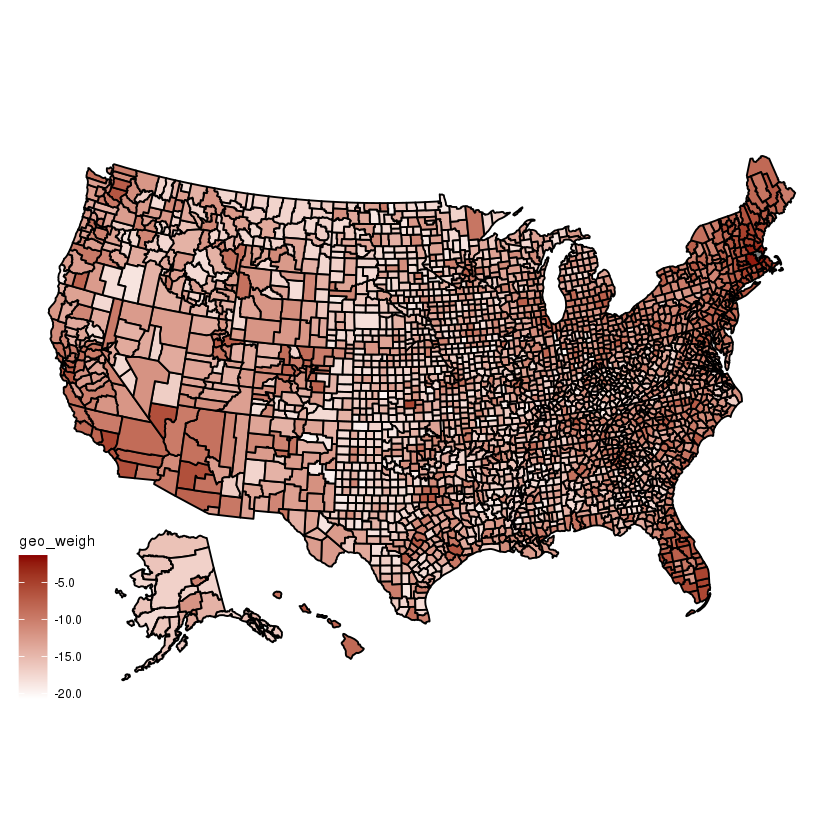

Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


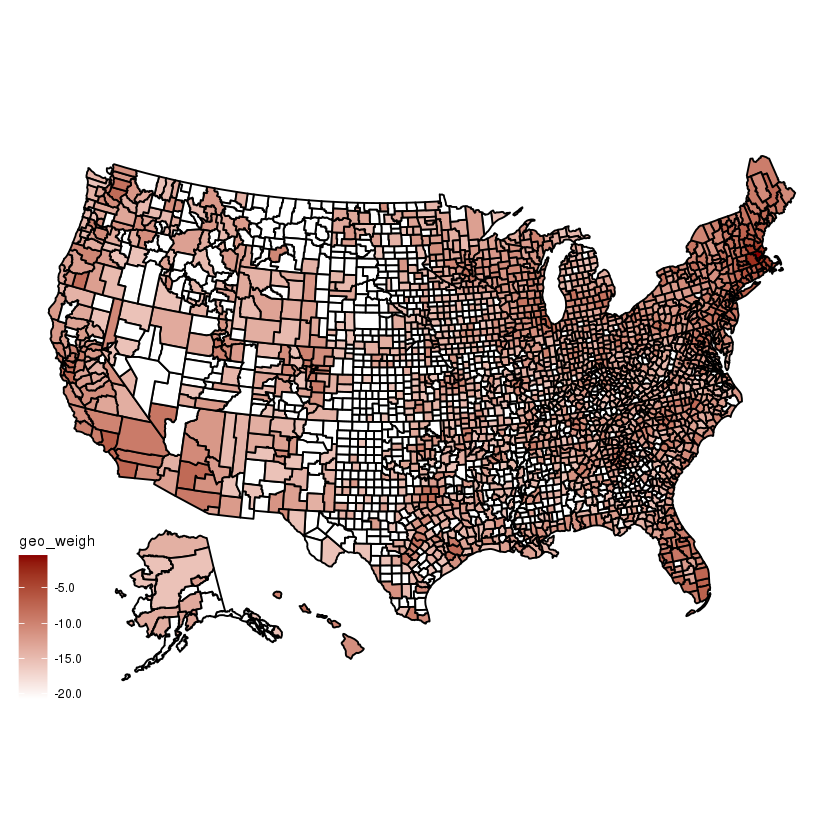

In [62]:
ii=25017 #MiddleSex

counties_fips <- colnames(geo_adj_matrix_bayes) #all counties

l <- which(counties_fips==ii) 
#From the county
a <- geo_adj_matrix_bayes[,l]
min_a <- min(a[a > 0])
ds <- data.frame(fips = counties_fips, 
                     geo_weigh = a)
ds$fips <- as.numeric(as.character(ds$fips))


ds_county <- countypop %>% as.data.frame() 
ds_county$fips <- as.numeric(ds_county$fips)
ds_county <- ds_county %>% left_join(ds, by="fips")
ds_county$geo_weigh <- log(ds_county$geo_weigh )



plot_usmap(data = ds_county, values = "geo_weigh") +   
 scale_fill_continuous( low="white", high="darkred",
                       name = "geo_weigh", label = scales::comma)

fn <- paste(fig_directory, 'middlesex_county_bayes.pdf', sep="")
ggsave(
  fn,
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 8,
  height = 8,
  units = c("in"),
  dpi = 300,
  limitsize = FALSE,
  useDingbats=FALSE
)


################ Also do this for the raw geo adj matrix
#From the county
a <- geo_adj_matrix[,l]

# normalize so it sums to 1.
a <- a / sum(a)
a[a == 0] = min_a

ds <- data.frame(fips = counties_fips, 
                     geo_weigh = a)
ds$fips <- as.numeric(as.character(ds$fips))


ds_county <- countypop %>% as.data.frame() 
ds_county$fips <- as.numeric(ds_county$fips)
ds_county <- ds_county %>% left_join(ds, by="fips")
ds_county$geo_weigh <- log(ds_county$geo_weigh )



plot_usmap(data = ds_county, values = "geo_weigh") +   
 scale_fill_continuous( low="white", high="darkred",
                       name = "geo_weigh", label = scales::comma)

fn <- paste(fig_directory, 'middlesex_county_raw.pdf', sep="")
ggsave(
  fn,
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1.2,
  width = 8,
  height = 8,
  units = c("in"),
  dpi = 300,
  limitsize = FALSE,
  useDingbats=FALSE
)



In [13]:
geo_adj_matrix_bayes_counts <- colSums(geo_adj_matrix_0_diag) * geo_adj_matrix_bayes

In [26]:
# Create a state-aggregated version of the Geo-Bayes Adjacency Matrix
as.data.frame(geo_adj_matrix_bayes_counts) %>%
    mutate(origin_county = rownames(geo_adj_matrix_bayes_counts)) %>%
    gather(key = 'dest_county', value = 'w', -origin_county) %>% 
    mutate(origin_state = floor(as.numeric(origin_county)/1000),
           dest_state = floor(as.numeric(dest_county)/1000)) %>% 
    group_by(origin_state, dest_state) %>% 
    summarise(w = sum(w)) %>% 
    ungroup() %>% 
    mutate(w = ifelse(origin_state == dest_state, 0 , w)) %>%
    group_by(dest_state) %>%
    mutate(w = w / sum(w)) %>% 
    spread(key = origin_state, value = w) %>% 
    ungroup() %>% 
    select(-dest_state) %>% 
    as.matrix() -> geo_bayes_state_level

Interpretation is either (a) the expected fraction or (b) the expected number of out-of-county visits that to county i that are from county j.

In [30]:
# Write to file.
save(geo_adj_matrix, geo_adj_matrix_bayes, geo_adj_matrix_bayes_counts, geo_bayes_state_level,
     file=paste0(
         c(processed_data_directory, 'geo_adjacency_matrix.Rdata'),
         sep='', collapse=''
     ))